In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import dotenv
import os
dotenv.load_dotenv()

from revert import models, infusion, transforms

# Pulse Generator

In this notebook, we train a conditional WGAN generator $g : Z \to X$ to reconstruct ICP pulse waveforms from their morphological feature vector $z \in Z$.  

In [9]:
""" Load encoder state """
state_dir   = os.environ['REVERT_LOGS']
model_name  = 'VICReg-64:8:64.pt'
# VICReg twin instance 
twins = models.Module.load(model_name)
# Model backbone : X -> Z
model = twins.model[1].freeze()
model

ConvNet([[1, 64, 8], [64, 16, 1], [8, 16]])

### 1. Conditional Dataset 

We first load the dataset returned by the pulse extraction pipeline. 

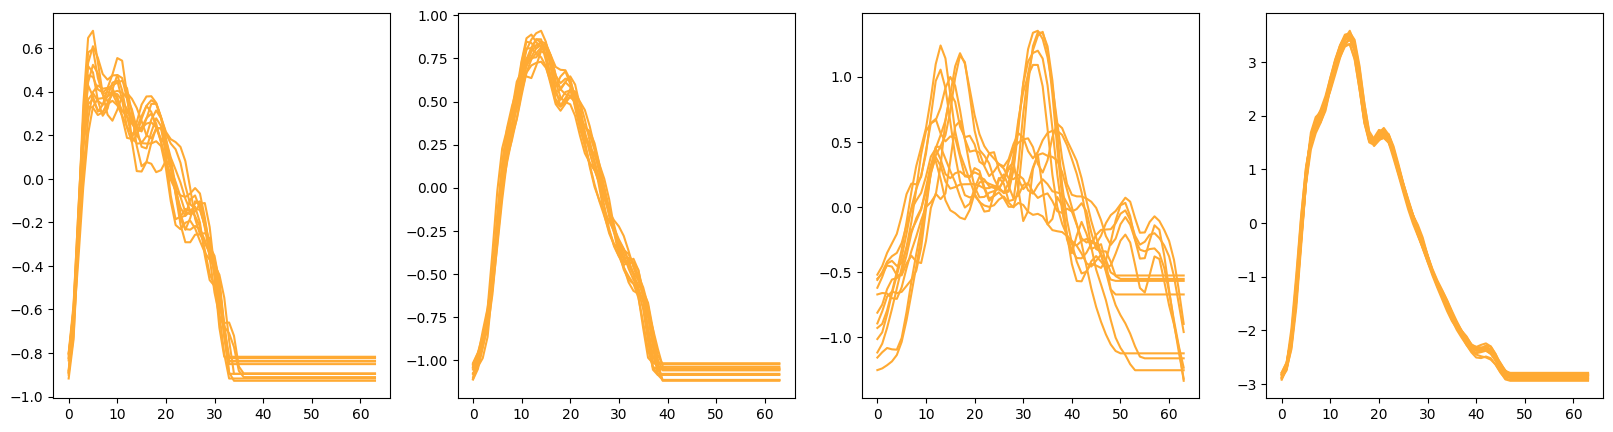

In [10]:
""" Load pulse dataset """
data_dir = os.environ['INFUSION_DATASETS']
data    = torch.load(os.path.join(data_dir, 'baseline-no_shunt.pt'))
pulses  = nn.AvgPool1d(2)(data['pulses'])
shuffle = transforms.Shuffle(0) 

# plot true samples
plt.figure(figsize=(20, 5))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.plot(shuffle(pulses)[i][:12].T, color='#fa3')

We will then pair each pulse $x \in X$ with its latent representation $f(x) \in Z$ 
to produce a conditional dataset for pulse generation. This means that the critic is trained to discriminate between the two following distributions: 

$$ (x, f(x)) \sim (g(z), z) $$

A small amount of noise should be added to the computent latent vectors, but we omit this detail for now. 

In [11]:
from revert.models import View 

xs      = shuffle(pulses[:1000].view([-1, 64]))
encoder = View([8]) @ model @ View([1, 64])

class ConditionalLoader(transforms.AugmentLoader): 
    """ Dataloader yielding pairs (f(x), x) from data batches x. """

    def __init__(self, data, encoder, Nbatch=256, eps=5e-2, **kws):
        self.data    = data
        self.encoder = encoder
        self.eps     = eps
        super().__init__(data, [], Nbatch, **kws)
    
    def augment(self, x):
        x = torch.stack(x)
        z = self.encoder(x)
        eps = torch.randn(z.shape) * .05 * z.std(0)[None,:]
        return z + eps, x

dset = ConditionalLoader(xs, encoder, Nbatch=256)


### 1. Generator architecture


In [12]:
def pulseGenerator(dz, dx):
    conv = models.ConvNet([[8, 16, 1],
                           [8, 16, 64],
                           [4, 4]])
    gen = models.Pipe(models.Linear(8, 64, 1),
                      View([8, 8]),
                      conv,
                      View([64]))
    return gen

In [13]:
gen = pulseGenerator(8, 64)

with torch.no_grad():
    x = gen(torch.randn(256, 8))

### 2. Critic architecture



In [14]:
def pulseCritic(dx, dz, layers=None):


    conv = models.Pipe(
        View([1, 64]),
        models.ConvNet([[1, 32, 8],
                        [64, 8, 1],
                        [8, 8]]),
        View([8]))
    

    critic = models.Pipe(
        models.Cut([64, 8], 1),
        models.Prod(conv, models.Id()),
        models.Cat(1),
        models.Affine(16, 1, 1)
    )

    return critic

critic = pulseCritic(64, 8)

### 3. Conditional WGAN fitting

In [15]:
wgan = models.WGAN.conditional(gen, critic, encoder, ns=(1, 20))

# fit critic on initial generator state 

def fitCritic(wgan, x_true, n=5):
    # generate initial distribution
    with torch.no_grad():
        z = wgan.encoder(x_true)
        p_gen  = wgan(z)
        p_true = torch.cat([z, x_true], 1)
        p = torch.cat([p_gen, p_true])
        y = wgan.critic.label(p_gen, p_true)
    # estimate Lipschitz constant
    N = 2096
    idx = torch.randint(p.shape[0], (N,))
    #with torch.no_grad():
    fp = wgan.critic(p[idx])
    #wgan.critic.lipschitz(fp, p[idx])
    # fit on initial distribution
    print(f"\n------ Initialize critic for {n} epochs ------\n")
    wgan.critic.fit((p, y), lr=1e-3, epochs=n, tag="critic initialization")

fp = fitCritic(wgan, shuffle(pulses[:1000].view([-1, 64])))


------ Initialize critic for 5 epochs ------



epoch: 100%|██████████| 5/5 [01:28<00:00, 17.66s/it]


In [16]:
wgan.fit(dset, lr=5e-4, epochs=10)
wgan.save('ConditionalWGAN-8:64.pt')

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

tensor([[-0.9487,  2.2917,  2.7355, -2.0863,  0.2426,  2.1928,  0.5067,  0.0048],
        [ 0.0212,  0.0164, -0.1576,  1.5440,  0.5133,  0.6764, -1.6374, -0.6011],
        [-0.5371,  1.2131,  2.0919, -1.5602,  0.1860,  1.4044, -0.1430,  0.6656],
        [ 0.1069, -0.3938, -1.9869,  1.4500,  1.8661, -1.0442,  1.5493, -0.2867],
        [-0.3120, -0.0280, -2.2178,  0.2032,  0.6866, -1.1196,  0.6536,  0.0243],
        [-0.5139,  0.0977,  1.1171, -0.9075, -0.6883,  2.1391,  0.0544,  0.1318]])


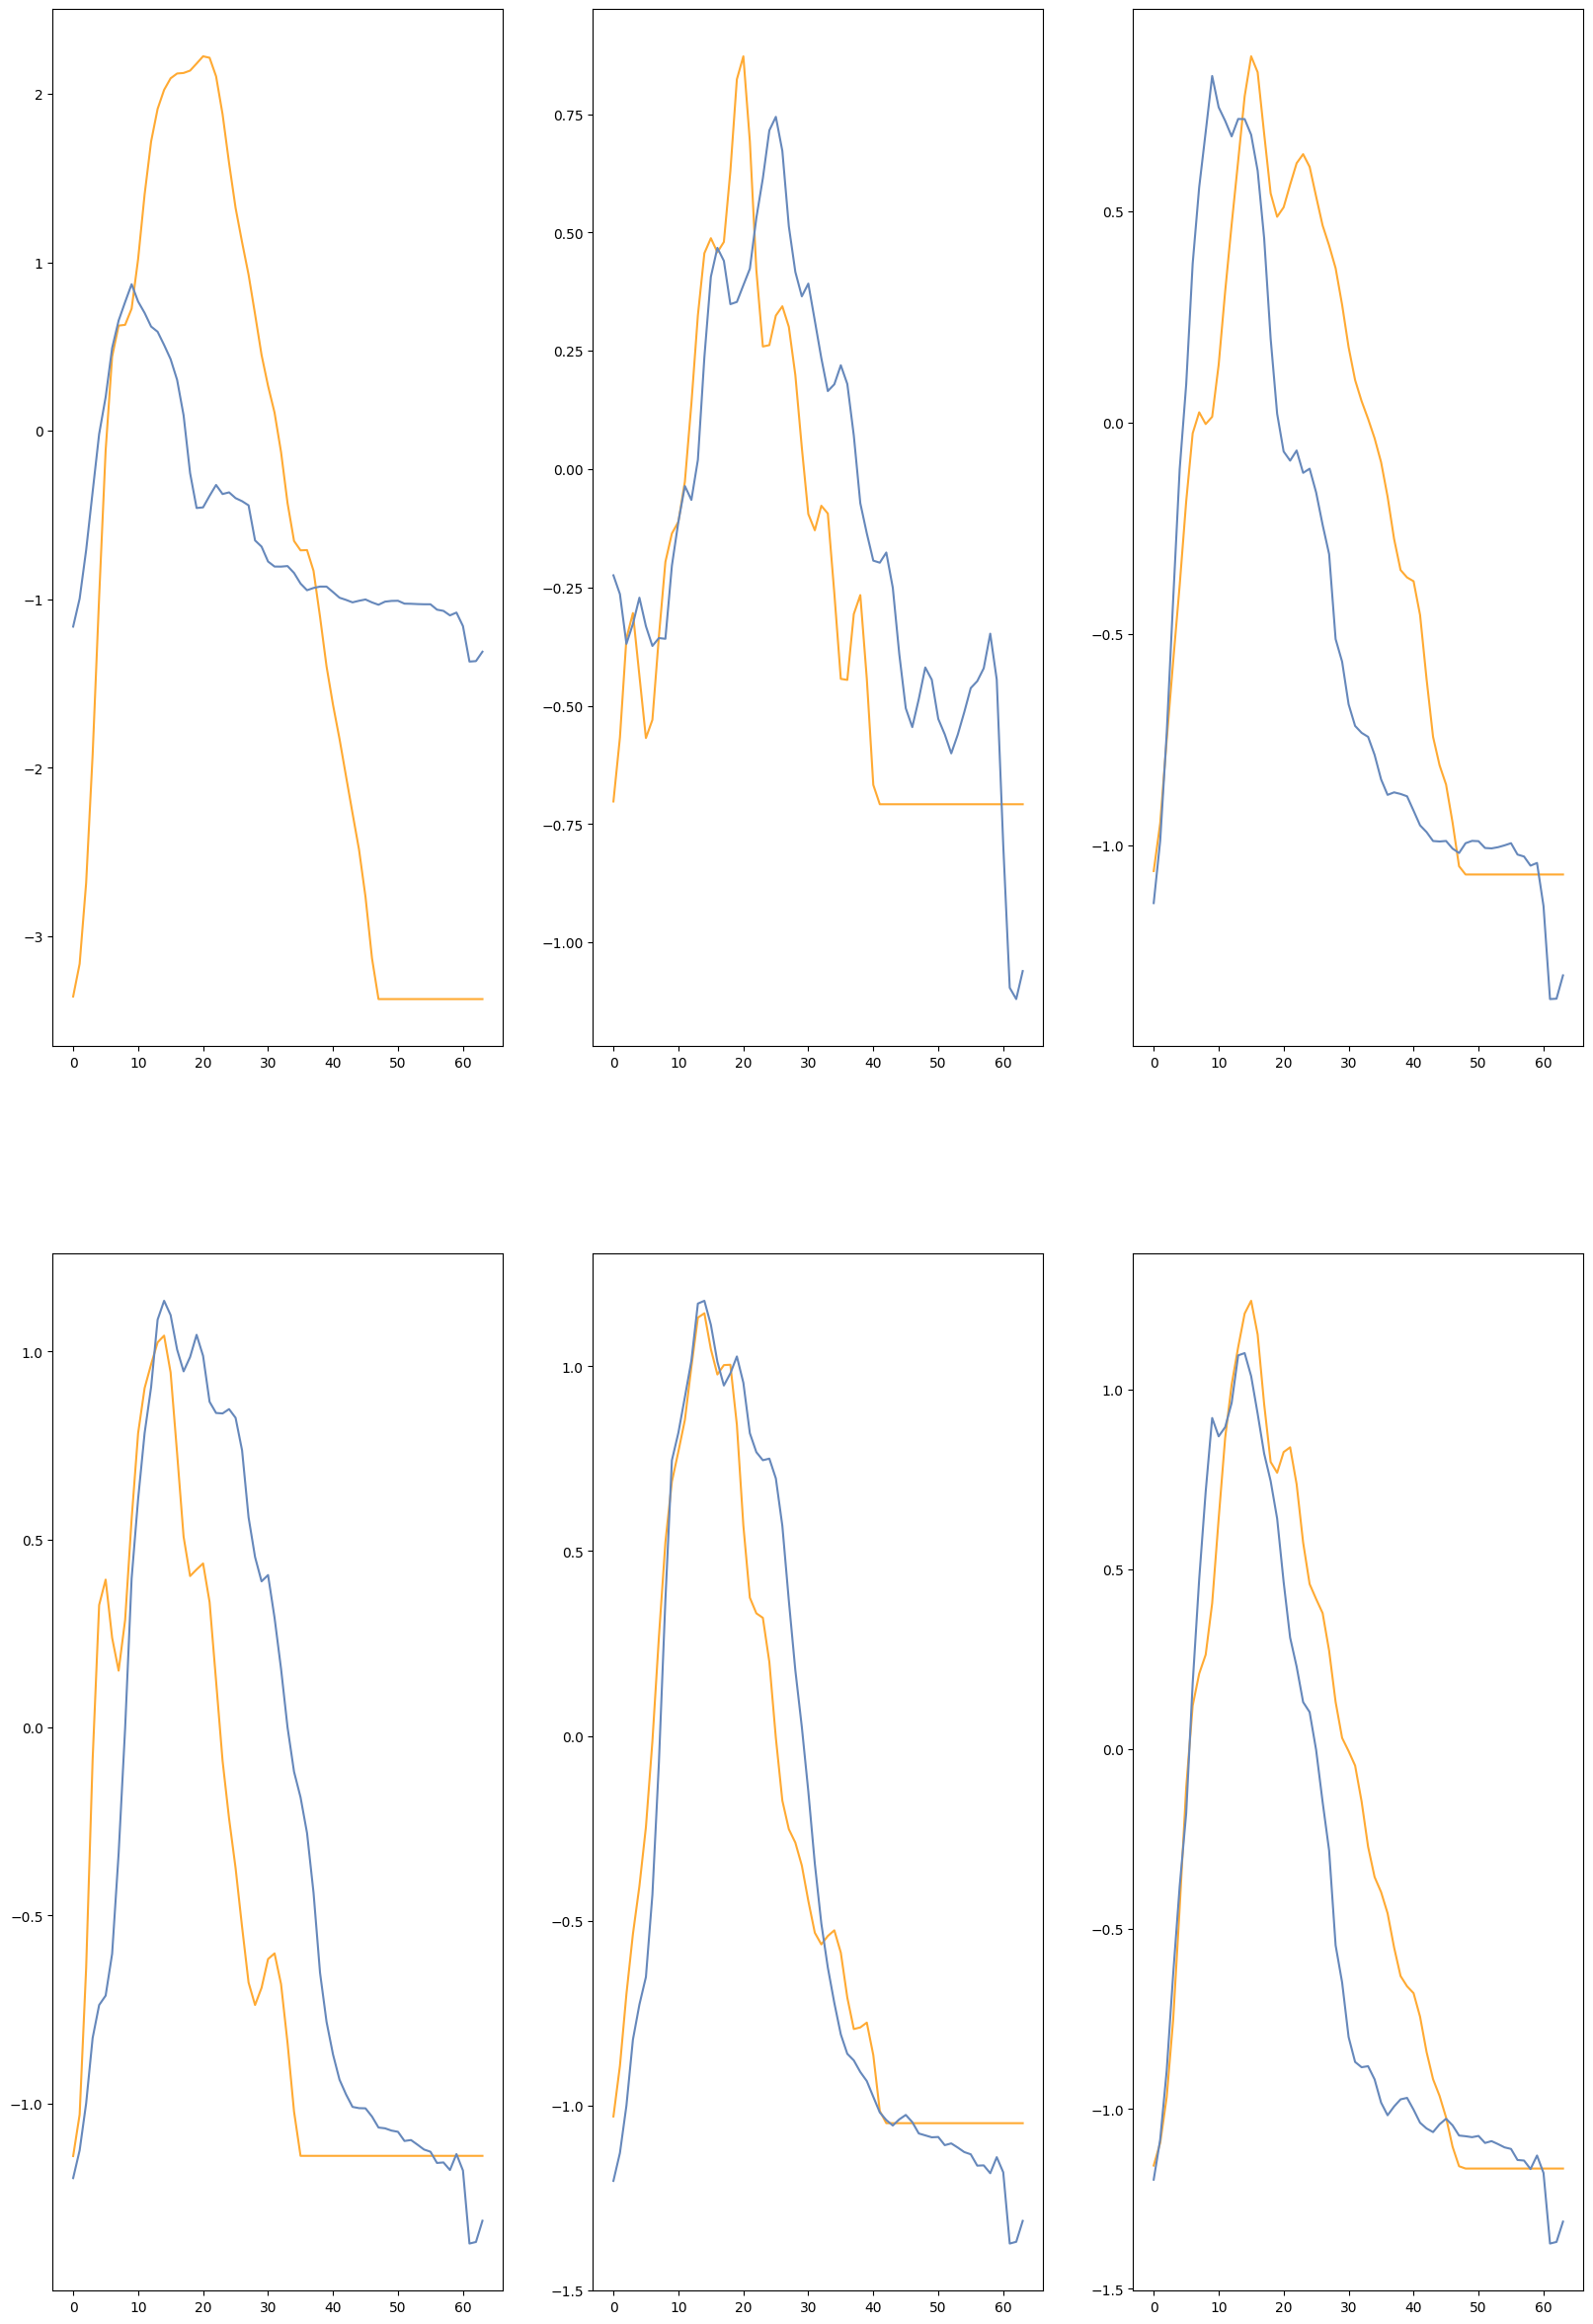

In [ ]:
plt.figure(figsize=(20, 30))

with torch.no_grad():
    x_true = shuffle(pulses)[:6, 0]
    z_true = wgan.encoder(x_true)
    x_gen = wgan.gen(z_true)
    z_gen = wgan.encoder(x_gen)
    print(z_gen - z_true)


    x_g = nn.AvgPool1d(2)(x_gen) 
    x_t = nn.AvgPool1d(2)(x_true)

for i, x in enumerate(shuffle(pulses[:6,0])):
    plt.subplot(2, 3, i+1)
    with torch.no_grad():
        plt.plot(x_t[i], color='#fa3')
        plt.plot(x_g[i], color='#68b')
